In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader


In [3]:
DATA_DIR = "/kaggle/input/braintumor"

IMG_TRAIN = os.path.join(DATA_DIR, "images/train")
IMG_VAL   = os.path.join(DATA_DIR, "images/val")
LBL_TRAIN = os.path.join(DATA_DIR, "labels/train")
LBL_VAL   = os.path.join(DATA_DIR, "labels/val")

In [4]:
def create_patches(img, label_path, patch_size=64, stride=64):
    """
    img: grayscale MRI image
    label_path: YOLO txt label file
    Returns: list of (patch, label)
    """
    h, w = img.shape[:2]
    
    # read bounding boxes
    boxes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls, x, y, bw, bh = map(float, line.strip().split())
                x, y, bw, bh = int(x*w), int(y*h), int(bw*w), int(bh*h)
                x1, y1 = x - bw//2, y - bh//2
                x2, y2 = x + bw//2, y + bh//2
                boxes.append((x1,y1,x2,y2))
    
    patches, labels = [], []
    for i in range(0, h-patch_size, stride):
        for j in range(0, w-patch_size, stride):
            patch = img[i:i+patch_size, j:j+patch_size]
            
            # check overlap with tumor boxes
            patch_label = 0
            for (x1,y1,x2,y2) in boxes:
                if j < x2 and j+patch_size > x1 and i < y2 and i+patch_size > y1:
                    patch_label = 1
                    break
            
            patches.append(cv2.resize(patch, (224,224)))  # resize for GoogleNet
            labels.append(patch_label)
    
    return patches, labels


In [5]:
def build_patch_dataset(img_dir, lbl_dir):
    X, y = [], []
    img_paths = glob(os.path.join(img_dir, "*.jpg")) + glob(os.path.join(img_dir, "*.png"))
    
    for img_path in img_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        lbl_path = os.path.join(lbl_dir, os.path.basename(img_path).replace(".jpg",".txt").replace(".png",".txt"))
        patches, labels = create_patches(img, lbl_path, patch_size=64, stride=64)
        X.extend(patches)
        y.extend(labels)
    
    return np.array(X), np.array(y)

X_train, y_train = build_patch_dataset(IMG_TRAIN, LBL_TRAIN)
X_val, y_val     = build_patch_dataset(IMG_VAL, LBL_VAL)

print("Train patches:", X_train.shape, "Labels:", np.unique(y_train, return_counts=True))
print("Val patches:", X_val.shape, "Labels:", np.unique(y_val, return_counts=True))


Train patches: (31506, 224, 224) Labels: (array([0, 1]), array([28680,  2826]))
Val patches: (8407, 224, 224) Labels: (array([0, 1]), array([7743,  664]))


In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Convert numpy → torch
X_train_torch = torch.tensor(X_train).unsqueeze(1).repeat(1,3,1,1).float()  # grayscale → 3 channels
y_train_torch = torch.tensor(y_train).long()

X_val_torch = torch.tensor(X_val).unsqueeze(1).repeat(1,3,1,1).float()
y_val_torch = torch.tensor(y_val).long()

train_dataset = TensorDataset(X_train_torch, y_train_torch)
val_dataset   = TensorDataset(X_val_torch, y_val_torch)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [7]:
vggnet = models.vgg16(pretrained=True)

# Replace the classifier for 2 classes
vggnet.classifier[6] = nn.Linear(vggnet.classifier[6].in_features, 2)

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vggnet = vggnet.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vggnet.parameters(), lr=0.0001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    vggnet.train()
    total, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vggnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    train_acc = 100 * correct / total

    # Validation
    vggnet.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vggnet(images)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    val_acc = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs} Train Acc: {train_acc:.2f}% Val Acc: {val_acc:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 126MB/s]  


Epoch 1/5 Train Acc: 91.10% Val Acc: 93.53%
Epoch 2/5 Train Acc: 94.48% Val Acc: 95.36%
Epoch 3/5 Train Acc: 95.65% Val Acc: 95.62%
Epoch 4/5 Train Acc: 96.38% Val Acc: 95.81%
Epoch 5/5 Train Acc: 96.89% Val Acc: 96.23%


In [17]:
import os
import torch
import cv2
import matplotlib.pyplot as plt
def visualize_dataset_samples(img_paths, model, labels_dir, device, num_images=10, dataset_name="Dataset"):
    """
    img_paths: list of image paths
    model: trained classification model
    labels_dir: folder containing label txt files (with bounding box info)
    device: torch device
    num_images: number of images to visualize
    dataset_name: name to display in titles
    """
    model.eval()
    plt.figure(figsize=(12, num_images * 5))
    
    for i, img_path in enumerate(img_paths[:num_images]):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
        
        # Read corresponding label file for bounding box
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        label_file = os.path.join(labels_dir, base_name + ".txt")
        
        with open(label_file, "r") as f:
            # Assuming format: class x_center y_center width height (normalized)
            line = f.readline().strip()
            parts = line.split()
            label = int(parts[0])
            x_c, y_c, bw, bh = map(float, parts[1:])
        
        # Convert bbox to pixels
        x1 = int((x_c - bw/2) * w)
        y1 = int((y_c - bh/2) * h)
        x2 = int((x_c + bw/2) * w)
        y2 = int((y_c + bh/2) * h)
        
        # Predict class
        from torchvision import transforms
        preprocess = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224,224)),
            transforms.ToTensor()
        ])
        img_tensor = preprocess(img).to(device)
        with torch.no_grad():
            output = model(img_tensor.unsqueeze(0))
            pred_class = output.argmax(1).item()
        
        # Prepare images for plotting
        img_left = img.copy()
        img_right = img.copy()
        
        # Draw bounding box
        cv2.rectangle(img_left, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.rectangle(img_right, (x1, y1), (x2, y2), (0,255,0), 2)
        
        # Add text: Left = actual class, Right = predicted class
        cv2.putText(img_left, f"A: {label}", (x1, max(y1-10,0)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2)
        color = (0,255,0) if pred_class == label else (255,0,0)
        cv2.putText(img_right, f"P: {pred_class}", (x1, max(y1-10,0)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
        
        # Plot side by side
        plt.subplot(num_images, 2, i*2 + 1)
        plt.imshow(img_left)
        plt.axis("off")
        plt.title(f"{dataset_name} - Ground Truth")
        
        plt.subplot(num_images, 2, i*2 + 2)
        plt.imshow(img_right)
        plt.axis("off")
        plt.title(f"{dataset_name} - Prediction")
    
    plt.tight_layout()
    plt.show()


        
# --- Compute train & val accuracy ---
def compute_accuracy(model, data_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

train_acc = compute_accuracy(vggnet, train_loader, device)
val_acc = compute_accuracy(vggnet, val_loader, device)
print(f"Training Accuracy: {train_acc:.2f}%")
print(f"Validation Accuracy: {val_acc:.2f}%")



Training Accuracy: 97.75%
Validation Accuracy: 96.23%


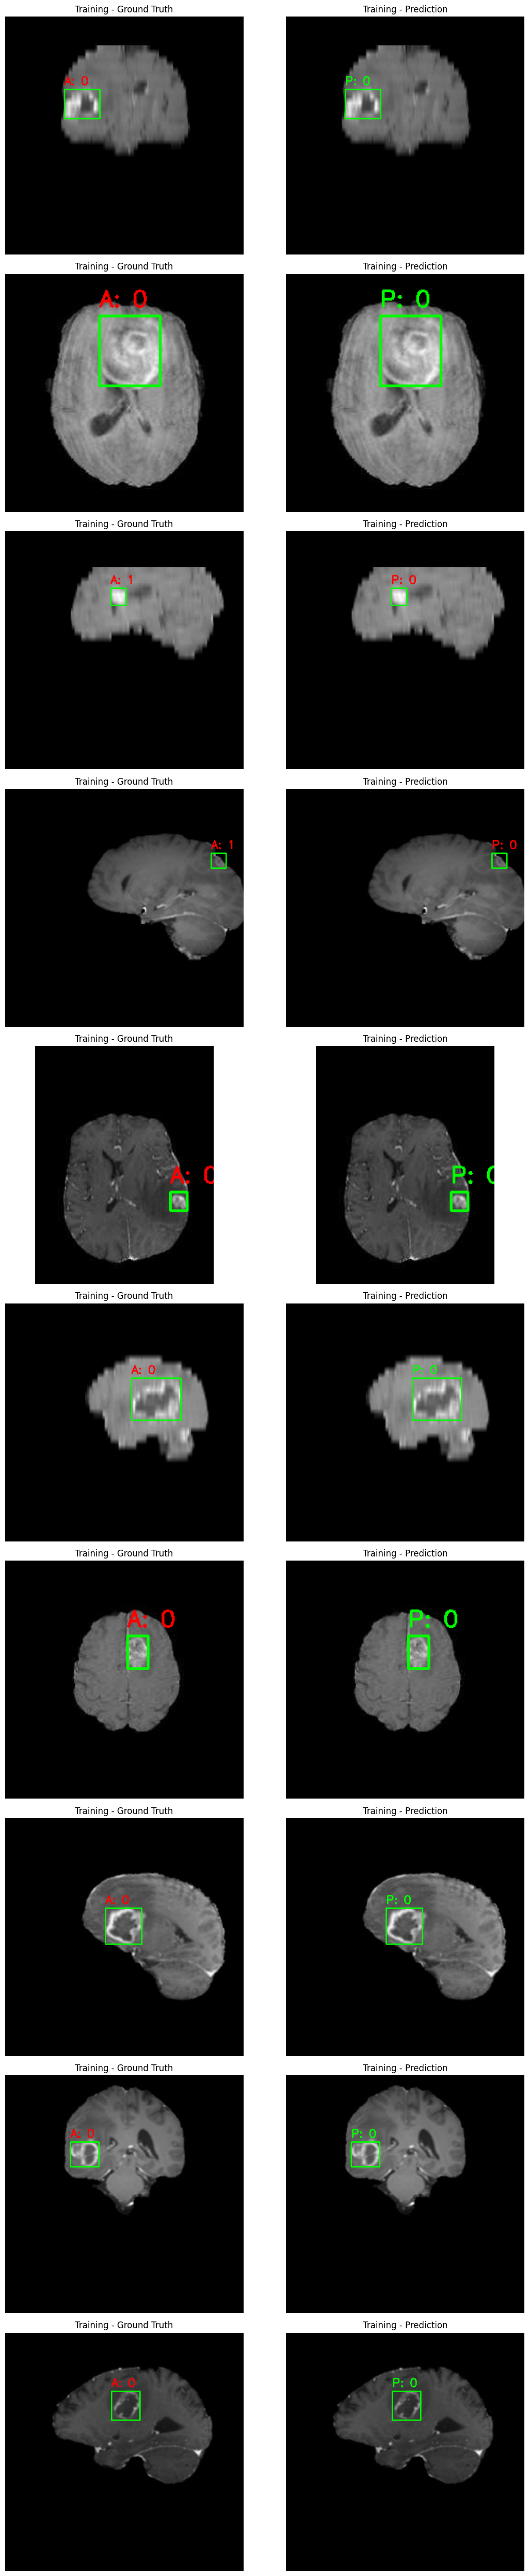

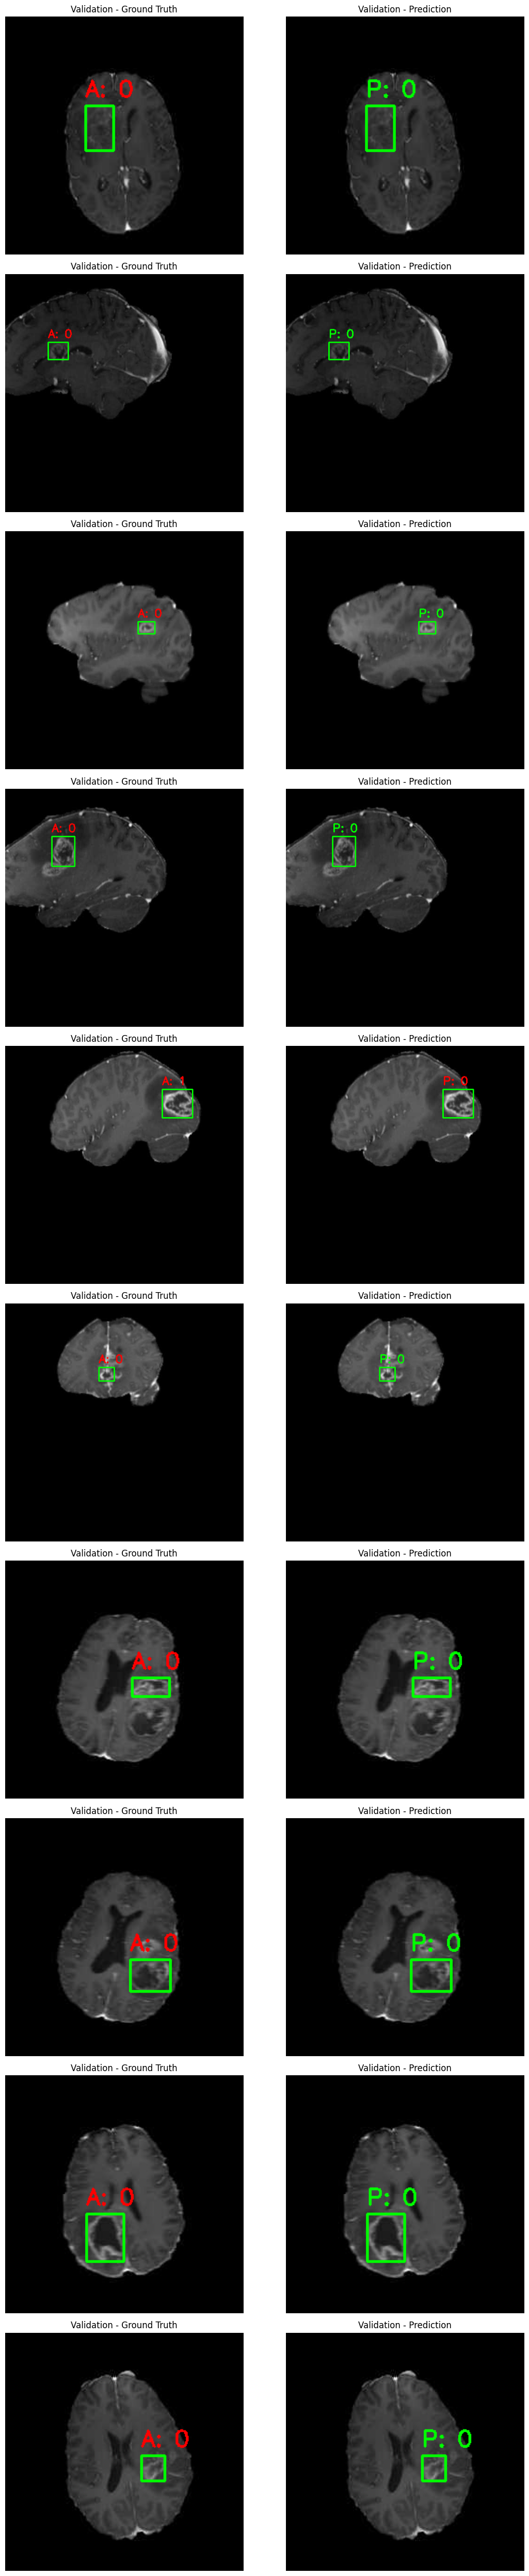

In [18]:

DATA_DIR = "/kaggle/input/braintumor"
IMG_TRAIN = os.path.join(DATA_DIR, "images/train")
IMG_VAL   = os.path.join(DATA_DIR, "images/val")
LBL_TRAIN = os.path.join(DATA_DIR, "labels/train")
LBL_VAL   = os.path.join(DATA_DIR, "labels/val")
# Training images
train_imgs = [os.path.join(IMG_TRAIN, f) for f in os.listdir(IMG_TRAIN)][:10]
visualize_dataset_samples(train_imgs, vggnet, LBL_TRAIN, device, num_images=10, dataset_name="Training")

# Validation images
val_imgs = [os.path.join(IMG_VAL, f) for f in os.listdir(IMG_VAL)][:10]
visualize_dataset_samples(val_imgs, vggnet, LBL_VAL, device, num_images=10, dataset_name="Validation")


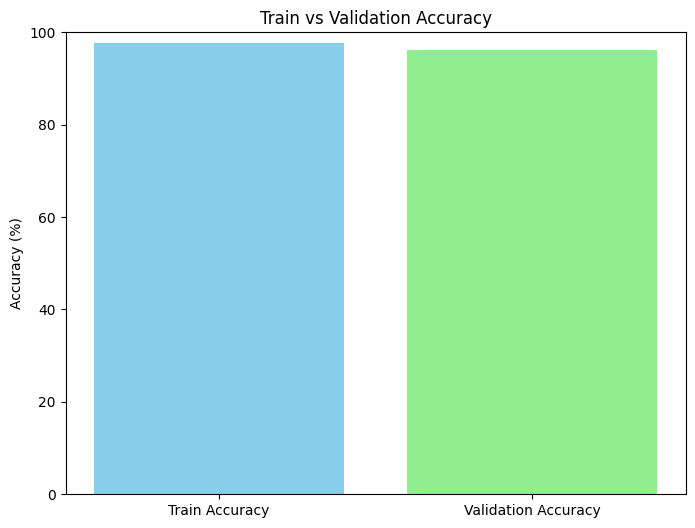

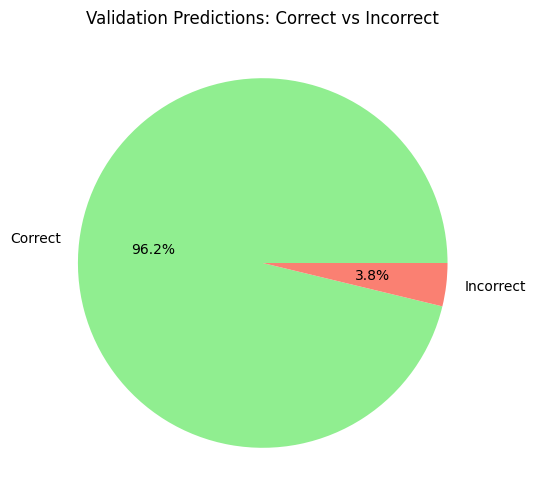

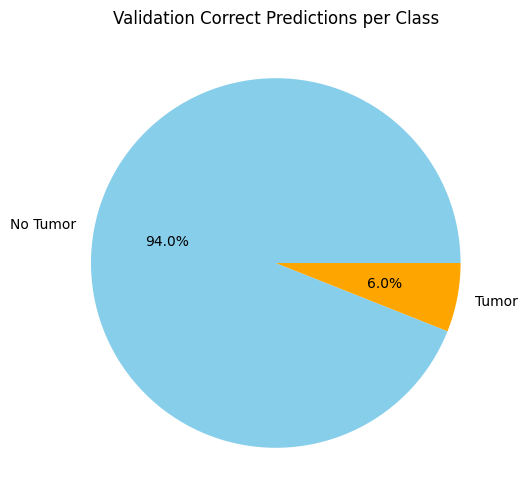

In [19]:
import matplotlib.pyplot as plt
import torch

# --- Compute metrics ---
def get_metrics(model, data_loader, device):
    """
    Returns:
    - accuracy
    - total correct/incorrect
    - class-wise counts
    """
    model.eval()
    correct, total = 0, 0
    class_counts = {0:0, 1:0}      # 0=No Tumor, 1=Tumor
    correct_counts = {0:0, 1:0}    # correct predictions per class
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            for l, p in zip(labels.cpu(), preds.cpu()):
                class_counts[l.item()] += 1
                if l.item() == p.item():
                    correct_counts[l.item()] += 1
                    
    accuracy = 100 * correct / total
    incorrect = total - correct
    return accuracy, correct, incorrect, class_counts, correct_counts

# --- Get metrics for validation ---
val_accuracy, val_correct, val_incorrect, val_class_counts, val_correct_counts = get_metrics(vggnet, val_loader, device)
train_accuracy, train_correct, train_incorrect, train_class_counts, train_correct_counts = get_metrics(vggnet, train_loader, device)

# --- Bar graph: Train vs Validation Accuracy ---
plt.figure(figsize=(8,6))
plt.bar(["Train Accuracy", "Validation Accuracy"], [train_accuracy, val_accuracy], color=["skyblue","lightgreen"])
plt.ylim(0,100)
plt.ylabel("Accuracy (%)")
plt.title("Train vs Validation Accuracy")
plt.show()

# --- Pie chart: Validation Correct vs Incorrect ---
plt.figure(figsize=(6,6))
plt.pie([val_correct, val_incorrect], labels=["Correct","Incorrect"], autopct="%1.1f%%", colors=["lightgreen","salmon"])
plt.title("Validation Predictions: Correct vs Incorrect")
plt.show()

# --- Pie chart: Class-wise distribution of correct predictions (Validation) ---
plt.figure(figsize=(6,6))
plt.pie([val_correct_counts[0], val_correct_counts[1]], labels=["No Tumor","Tumor"], autopct="%1.1f%%", colors=["skyblue","orange"])
plt.title("Validation Correct Predictions per Class")
plt.show()


Accuracy: 96.23%
Precision: 0.78
Recall: 0.73
F1 Score: 0.75


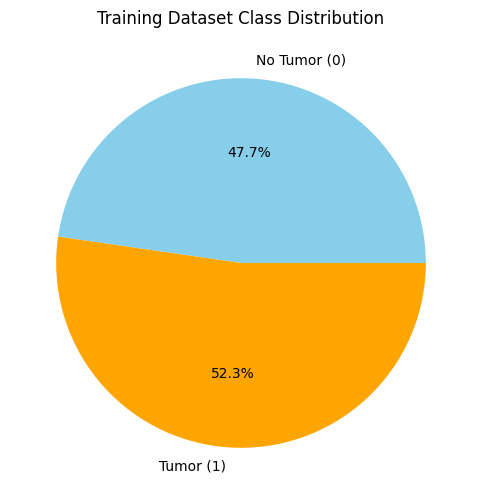

In [22]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def compute_classification_metrics(model, data_loader, device):
    """
    Computes accuracy, precision, recall, f1 score
    Returns metrics dict and class distribution
    """
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    # Class distribution in dataset
    class_counts = [all_labels.count(0), all_labels.count(1)]
    
    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }
    
    return metrics, class_counts

# --- Compute metrics for validation/test dataset ---
metrics, class_counts = compute_classification_metrics(vggnet, val_loader, device)

# Print metrics
print(f"Accuracy: {metrics['accuracy']:.2f}%")
print(f"Precision: {metrics['precision']:.2f}")
print(f"Recall: {metrics['recall']:.2f}")
print(f"F1 Score: {metrics['f1_score']:.2f}")

# --- Pie chart for class distribution ---
import os
import matplotlib.pyplot as plt

# Count the number of images per class in training dataset
def get_class_distribution(labels_dir):
    class_counts = [0, 0]  # [No Tumor (0), Tumor (1)]
    for fname in os.listdir(labels_dir):
        label_file = os.path.join(labels_dir, fname)
        with open(label_file, "r") as f:
            line = f.readline().strip()
            if line:  # if label file is not empty
                label = int(line.split()[0])
                class_counts[label] += 1
    return class_counts

# Get distribution
train_class_counts = get_class_distribution(LBL_TRAIN)

# Plot pie chart
labels = ["No Tumor (0)", "Tumor (1)"]
colors = ["skyblue", "orange"]

plt.figure(figsize=(6,6))
plt.pie(train_class_counts, labels=labels, autopct="%1.1f%%", colors=colors)
plt.title("Training Dataset Class Distribution")
plt.show()


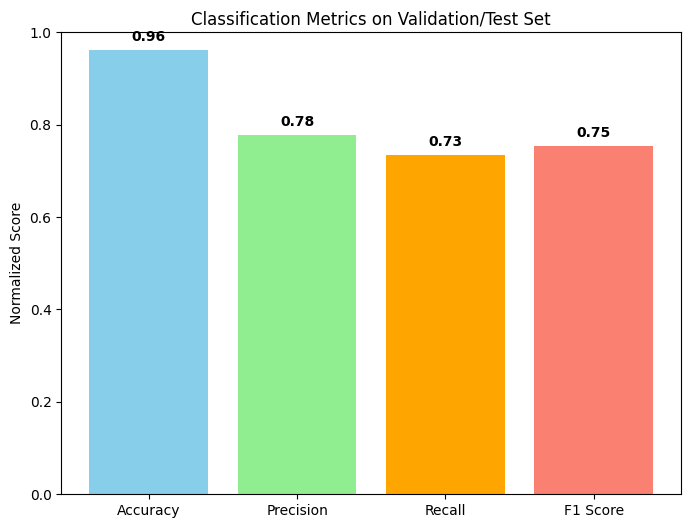

In [21]:
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_classification_metrics(model, data_loader, device):
    """
    Computes accuracy, precision, recall, f1 score
    Returns metrics dict
    """
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }
    
    return metrics

# --- Compute metrics for validation/test dataset ---
metrics = compute_classification_metrics(vggnet, val_loader, device)

# --- Normalize metrics to 0-1 (they already are in 0-1 except accuracy as fraction) ---
normalized_metrics = {k: v for k, v in metrics.items()}

# --- Plot bar graph ---
plt.figure(figsize=(8,6))
plt.bar(normalized_metrics.keys(), normalized_metrics.values(), color=["skyblue","lightgreen","orange","salmon"])
plt.ylim(0,1)
plt.ylabel("Normalized Score")
plt.title("Classification Metrics on Validation/Test Set")
for i, v in enumerate(normalized_metrics.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()
